# Simple CAR model

This notebook simply models temperature in Durham using the CAR model, with just the weather stations to reference.

In [2]:
import numpy as np
import rasterio as rio
from matplotlib import pyplot as plt
from sklearn.feature_extraction import image
from libpysal.weights import lat2W

import pymc as pm
import arviz as az

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [3]:
# Load the data and preprocess it for analysis
with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif') as src:
    data = src.read(1)

# Construct adjacency matrix
adj = lat2W(data.shape[0], data.shape[1]).to_sparse()

# Create adjacency matrix for the gridded data
temp = np.ma.masked_values(data, value=0)

# Reshape the data to be 1D
N = temp.shape[0] * temp.shape[1]
temp_flat = temp.flatten()

In [47]:
with pm.Model() as model:

    # Priors
    sigma = pm.InverseGamma('sigma', 1,1)
    eps = pm.InverseGamma('eps', 1, 1)
    mu = pm.Normal('mu', mu=np.nanmean(temp), sigma=10)
    phi = pm.ICAR('phi', W=adj.todense(), zero_sum_stdev=1)

    # Likelihood
    T = pm.Normal('temp', mu + phi*sigma, sigma=eps, observed=temp_flat)
    # Assume a measurement error of 0.5 degrees
    # T = pm.Normal('temp', mu = T_est, sigma=0.5, observed=temp_flat)

    # Sample
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.99)

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, eps, mu, phi, temp_unobserved]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 221 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [48]:
mean_temp = trace.posterior['temp'].mean(axis=(0,1)).values

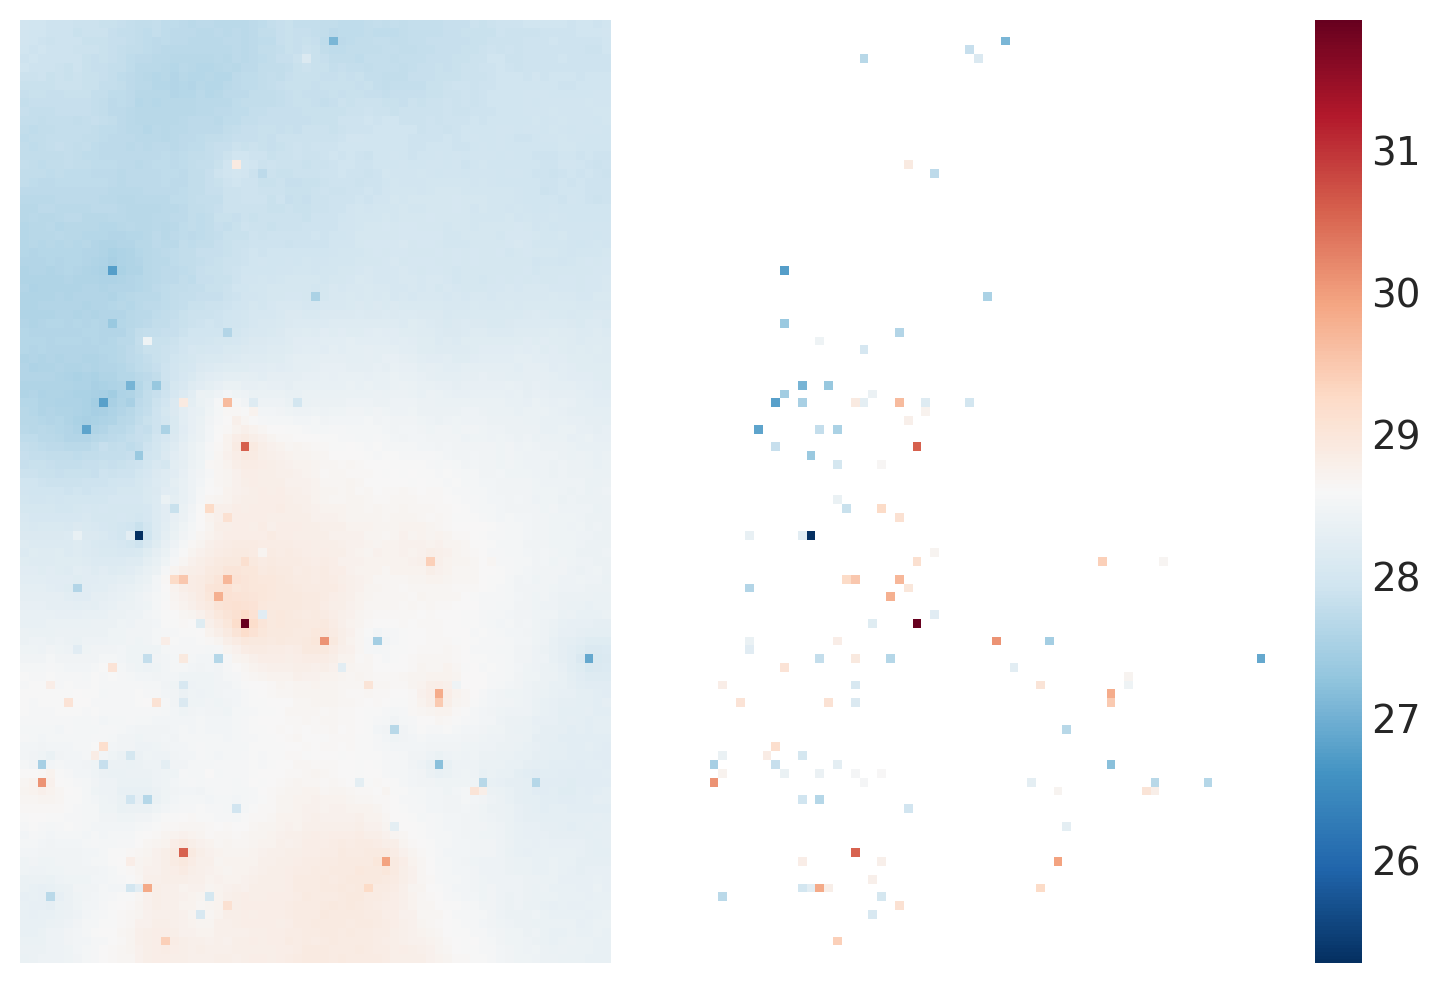

In [49]:
plt.subplot(1,2,1)
plt.imshow(mean_temp.reshape(temp.shape), cmap='RdBu_r')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(temp, cmap='RdBu_r')
plt.axis('off')
plt.colorbar()

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'eps'}>, <Axes: title={'center': 'eps'}>]],
      dtype=object)

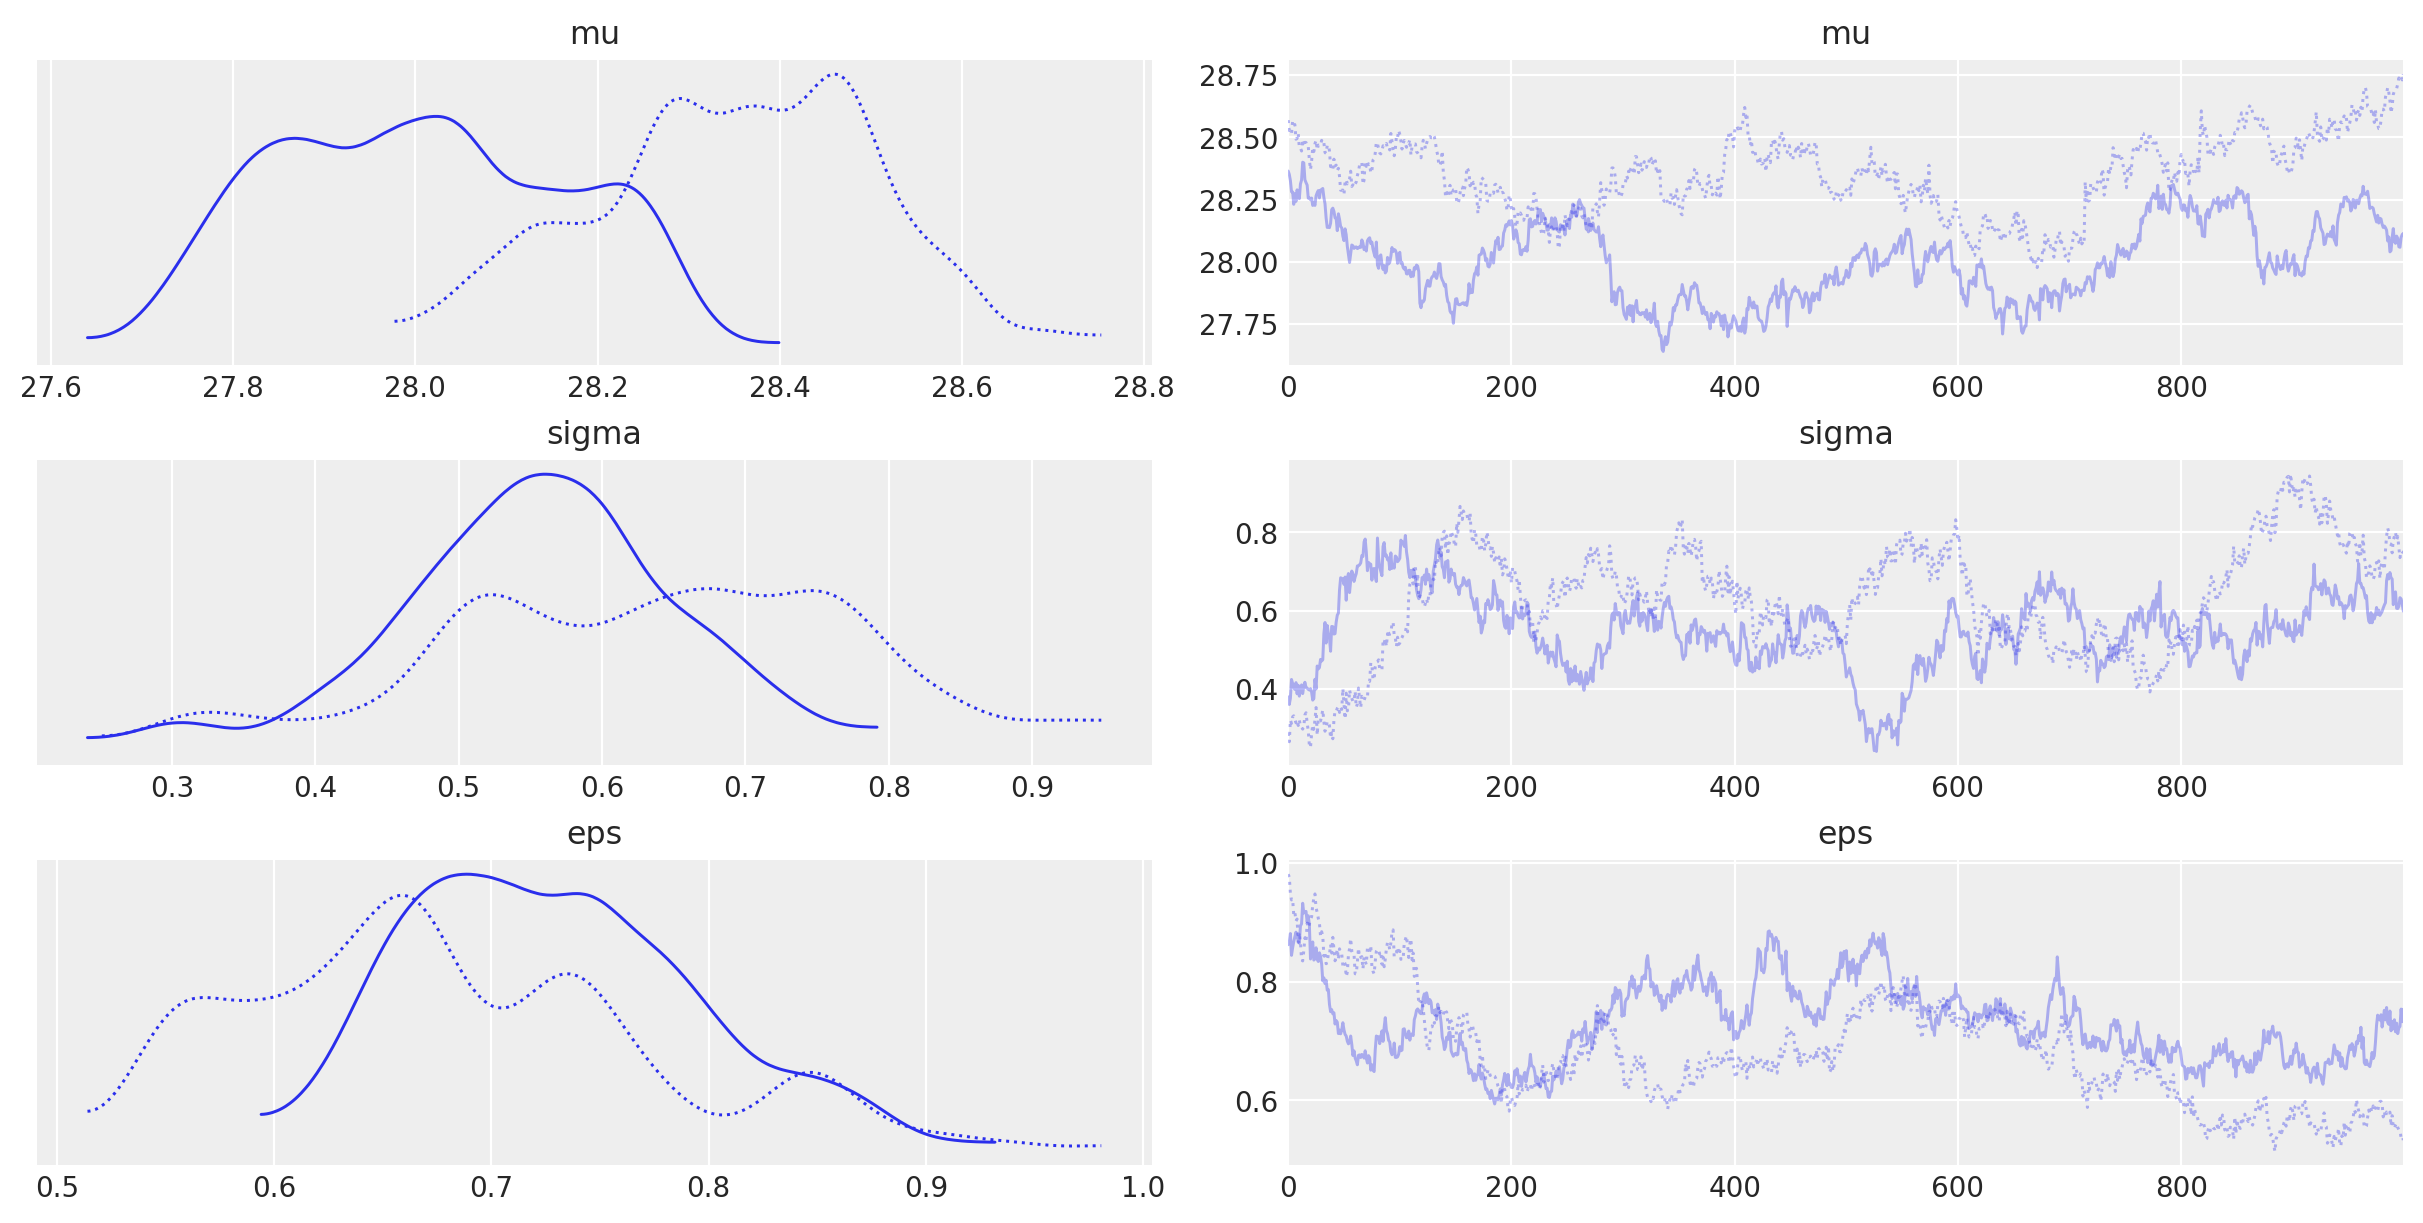

In [50]:
az.plot_trace(trace, var_names=['mu', 'sigma', 'eps'])

This is FINE...not great, but not horrible, either.

In [51]:
# Save the mean temperature as a TIF, using the same metadata as the original
# data
with rio.open('../data/preprocessed/temperature/durham_stations_w_temp_500m.tif') as src:
    # Copy the metadata and save the data into a new raster
    with rio.open('../results/rasterized/m1.tif', 'w', **src.meta) as dst:
        dst.write(mean_temp.reshape(temp.shape), 1)


# What if observations are noisy?

In this reparameterization of the model, we look at the temperature as if it were noisy, which allows us to understand the potential impact of measurement error (especially given the network).

In [74]:
N

6262

In [42]:
with pm.Model() as model:

    # Priors
    sigma = pm.Exponential('sigma', 1)
    eps = pm.Exponential('eps', 1)
    mu = pm.Normal('mu', mu=np.nanmean(temp), sigma=0.1)
    phi = pm.ICAR('phi', W=adj.todense())

    # Likelihood
    T = pm.Normal('temp', mu + sigma*phi, sigma=eps, observed=temp_flat)
    # T = pm.Normal('temp', mu=T_est, sigma=0.2, observed=temp_flat)
    
    # Sample
    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.95)

/Users/zdc6/mambaforge/envs/pspws/lib/python3.11/site-packages/pymc/model/core.py:1323: ImputationWarning: Data in temp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [sigma, eps, mu, phi, temp_unobserved]


ValueError: Not enough samples to build a trace.

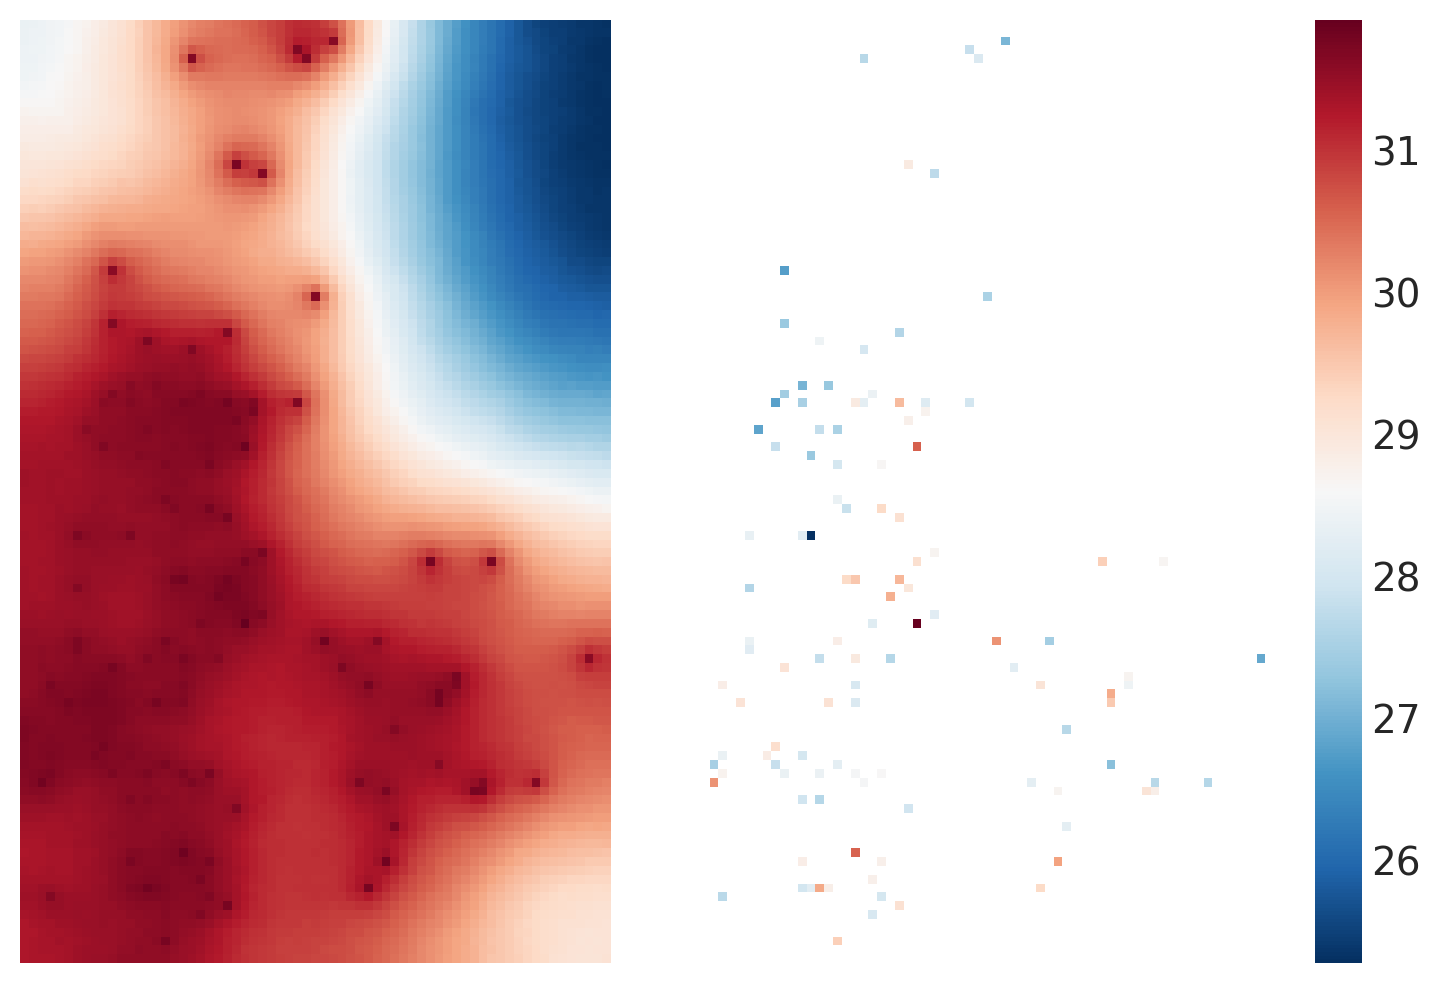

In [36]:
mean_temp = trace.posterior['temp'].mean(axis=(0,1)).values

plt.subplot(1,2,1)
plt.imshow(mean_temp.reshape(temp.shape), cmap='RdBu_r')#, vmax=temp.max(), vmin=temp.min())
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(temp, cmap='RdBu_r')
plt.axis('off')
plt.colorbar()

In [39]:
az.summary(trace, var_names=[ 'sigma', 'eps'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,16.083,0.927,14.440,17.691,0.169,0.121,31.0,153.0,1.03
eps,4.454,0.905,3.341,6.449,0.372,0.278,6.0,30.0,1.25


KeyboardInterrupt: 

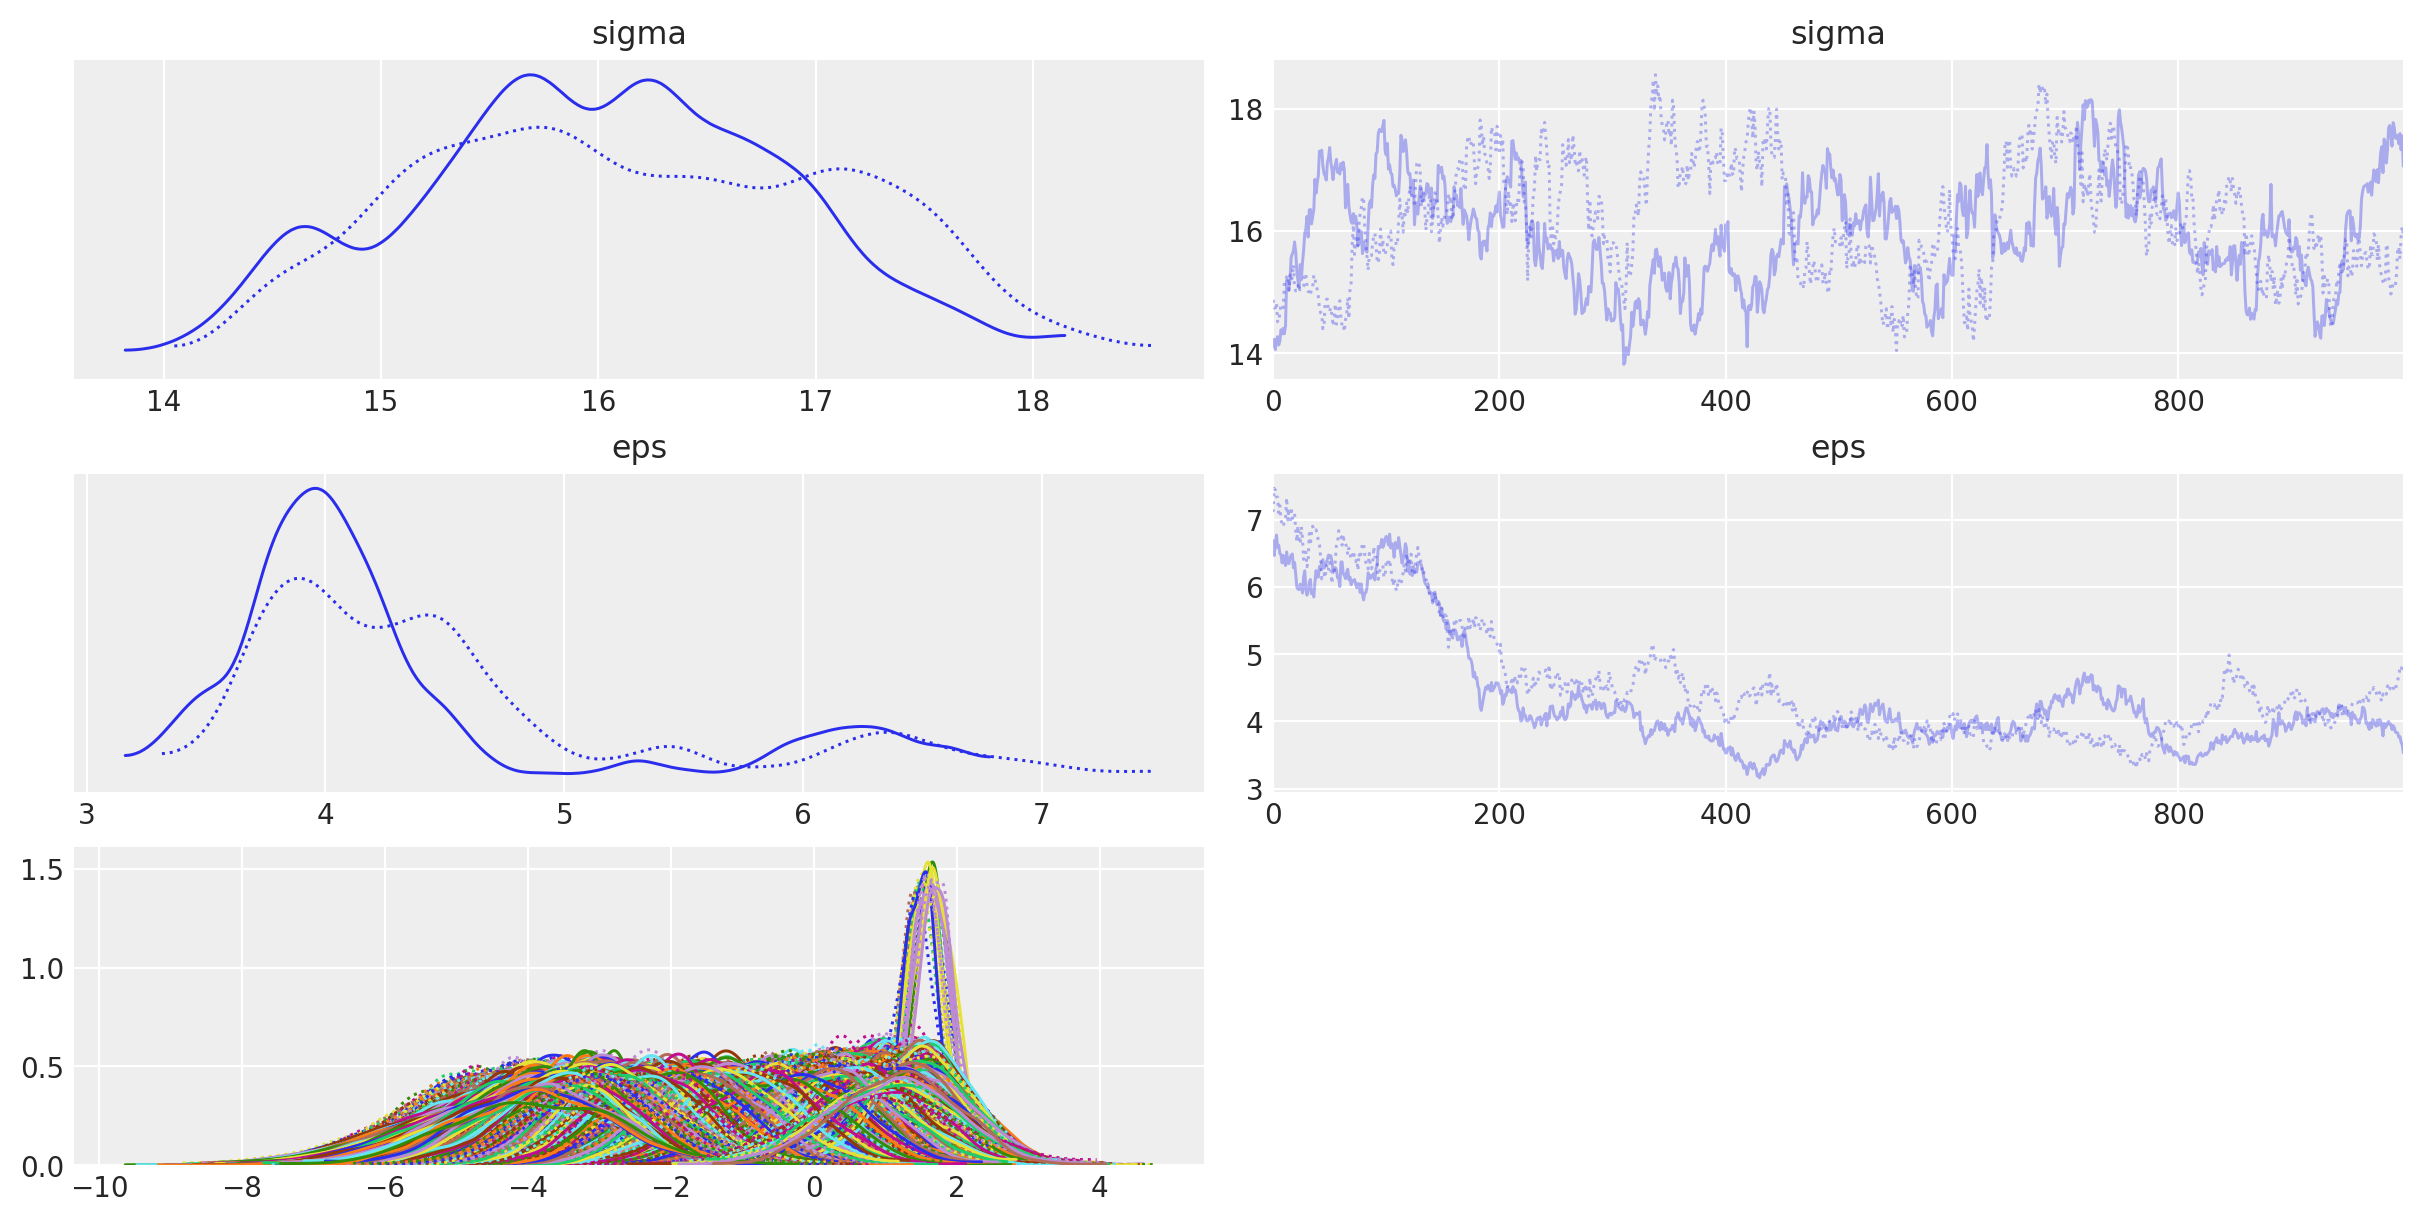

In [41]:
az.plot_trace(trace.posterior[['sigma','eps', 'phi']])

In [25]:
mean_temp.max()

31.919086021505734

In [26]:
mean_temp_act = trace.posterior['temp'].mean(axis=(0,1)).values

In [27]:
mean_temp_act.max()

31.919086021505734

# Add the map of Durham


In [89]:
with rio.open('../data/census/durham_geoid.tif') as src:
    census = src.read(1)

In [92]:
census[census != 0] = 1

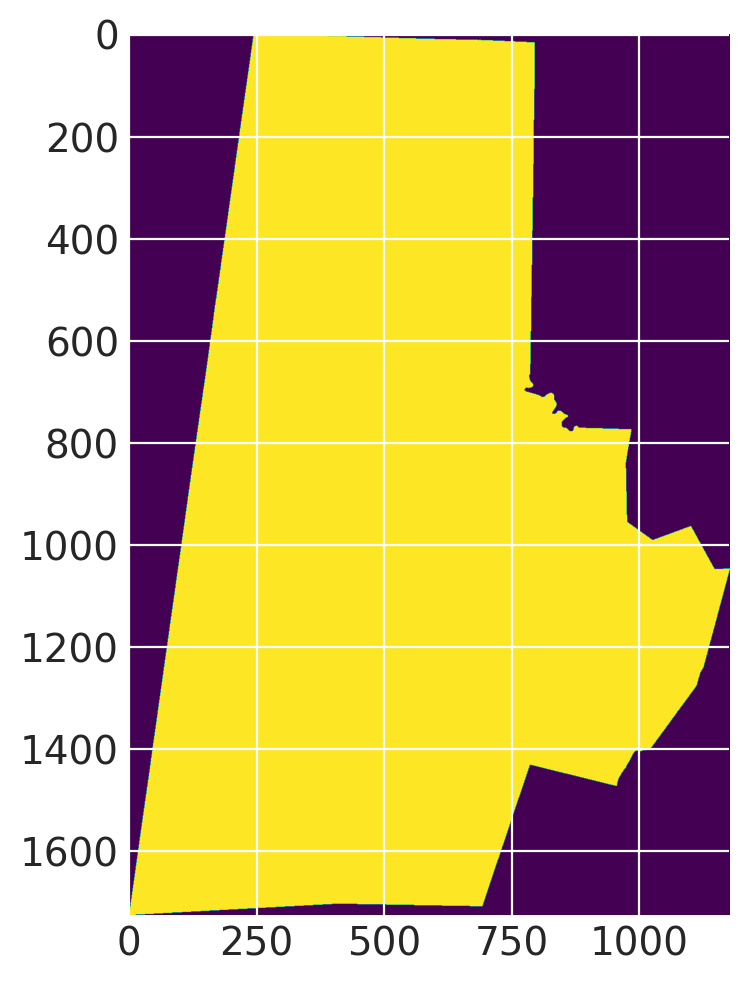

In [93]:
plt.imshow(census)

In [97]:
# res = mean_temp.reshape(temp.shape)*census

print(temp.shape[1]/temp.shape[0])
print(census.shape[1]/census.shape[0])

0.6138613861386139
0.6813441483198146
